## Análisis de Opiniones y Características de Listados de Airbnb en Ciudad México

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import nltk
import joblib
import importlib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import textfunctions
import plots
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/tux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tux/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/tux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Carga de los datos y exploración inicial
- Cargamos los datos de Airbnb y realizamos una exploración inicial para entender la estructura y el contenido de los datos.
- Exploramos la columna objetivo: `review_scores_rating`.
- Eliminamos los items sin puntuación.
- Realizamos el etiquetado binario.
- Visualizamos la distribución de la nueva columna `target`.

In [2]:
df_listings = pd.read_csv('data/listings.csv')
df_reviews = pd.read_csv('data/reviews.csv')

- Revisamos la cantida de datos que tenemos en ambos dataframes.
- Verificamos que en los reviews no hayan ids que no se encuentren en listings.

In [3]:
print("Tamaño de df_listings:", df_listings.shape)
print("Tamaño de df_reviews:", df_reviews.shape)

Tamaño de df_listings: (26067, 79)
Tamaño de df_reviews: (1315986, 6)


In [4]:
missing_ids = set(df_reviews['listing_id']) - set(df_listings['id'])

In [5]:

print(f"Total de propiedades: {df_listings['id'].nunique()}")
print(f"Total de reseñas: {len(df_reviews)}")
print(f"Total de propiedades únicas reseñadas: {df_reviews['listing_id'].nunique()}")
print(f"Avg Reseñas/Propiedades: {len(df_reviews)/df_reviews['listing_id'].nunique():.1f}")

Total de propiedades: 26067
Total de reseñas: 1315986
Total de propiedades únicas reseñadas: 22806
Avg Reseñas/Propiedades: 57.7


In [6]:
print("Valores nulos en la variable objetivo: ",df_listings['review_scores_rating'].isnull().sum())
df_listings = df_listings.dropna(subset=['review_scores_rating'])
print("Valores nulos en la variable objetivo después de eliminar: ",df_listings['review_scores_rating'].isnull().sum())

Valores nulos en la variable objetivo:  3261
Valores nulos en la variable objetivo después de eliminar:  0


In [7]:
df_listings["target"] = (df_listings["review_scores_rating"] >=4.5).astype(int)
print(df_listings["target"].value_counts())

target
1    20565
0     2241
Name: count, dtype: int64


/tmp/ipykernel_20694/4122031400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_listings, x='target', palette='viridis')


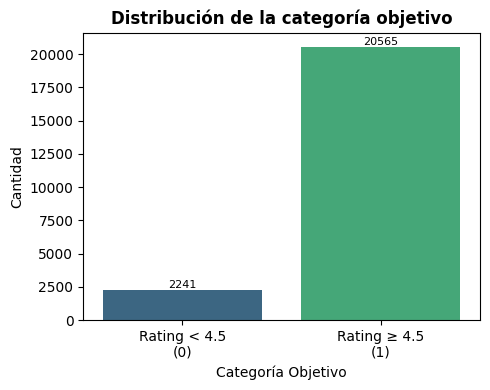

In [8]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df_listings, x='target', palette='viridis')

# Add labels and title
plt.title('Distribución de la categoría objetivo', fontsize=12, fontweight='bold')
plt.xlabel('Categoría Objetivo', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)

# Add value labels on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.xticks([0, 1], ['Rating < 4.5\n(0)', 'Rating ≥ 4.5\n(1)'])

# Adjust layout and display
plt.tight_layout()
plt.show()

Notamos que hay un gran desbalance en la categoría objetivo. Esto será algo importante a tener en cuenta al momento de elegir, entrenar y evaluar los modelos.

## 2. Preprocesamiento del texto
- Eliminamos las filas con valores nulos.
- Eliminamos caracteres especiales, números y stopwords.
- Convertimos todo a minúsculas.
- Realizamos lematización para reducir las palabras a su forma base.
- Creamos una nueva columna en el dataframe de reviews con el texto preprocesado.

Utilizaremos la columna `comments` del dataframe de reviews para el análisis, ya que está nos ayudará a entender mejor las opiniones de los usuarios que son quienes hacen las reseñas.

In [9]:
print("Reseñas sin comentarios: ",df_reviews['comments'].isnull().sum())
df_reviews = df_reviews.dropna(subset=['comments'])
print("Reseñas sin comentarios luego de la limpieza: ",df_reviews['comments'].isnull().sum())

Reseñas sin comentarios:  167
Reseñas sin comentarios luego de la limpieza:  0


In [ ]:
# df_reviews = df_reviews.copy()
# df_reviews["comment_language"] = df_reviews["comments"].apply(textfunctions.detect_language)

In [11]:
# print(df_reviews["comment_language"].value_counts())
# print(df_reviews["comment_language"].value_counts(normalize=True) * 100)

comment_language
es         789738
en         474135
pt          11076
fr          10831
unknown     10656
            ...  
nap             1
sco             1
pam             1
be              1
az              1
Name: count, Length: 74, dtype: int64
comment_language
es         60.018741
en         36.033451
pt          0.841757
fr          0.823138
unknown     0.809838
             ...    
nap         0.000076
sco         0.000076
pam         0.000076
be          0.000076
az          0.000076
Name: proportion, Length: 74, dtype: float64


Nota: Se decidió continuar el análisis con únicamente reseñas en inglés para simplificar el modelo y el preprocesamiento. No obstante, es posible que esta decisión introduzca un sesgo geográfico o socioeconómico.

In [12]:
# df_reviews = df_reviews[df_reviews["comment_language"].isin(["en", "es"])].copy()
# print(df_reviews["comment_language"].value_counts())
# print(df_reviews["comment_language"].value_counts(normalize=True) * 100)

# df_reviews_en = df_reviews[df_reviews["comment_language"] == "en"].copy()

comment_language
es    789738
en    474135
Name: count, dtype: int64
comment_language
es    62.48555
en    37.51445
Name: proportion, dtype: float64


In [13]:
importlib.reload(textfunctions)

[nltk_data] Downloading package stopwords to /home/tux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tux/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/tux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'textfunctions' from '/home/tux/airbnb_comments/textfunctions.py'>

In [ ]:
# df_reviews_en["clean_comments"] = df_reviews_en["comments"].apply(textfunctions.clean_text)

In [15]:
#df_reviews_en["lemmatized_1"] = df_reviews_en["clean_comments"].apply(textfunctions.lemmatize_text)

In [16]:
#df_reviews_en["lemmatized"] = textfunctions.lemmatize_text_spacy_batch(df_reviews_en["clean_comments"])

In [17]:
#df_reviews_en["final_comments_1"] = df_reviews_en["lemmatized_1"].apply(textfunctions.remove_stopwords)

In [18]:
#df_reviews_en["final_comments"] = df_reviews_en["lemmatized"].apply(textfunctions.remove_stopwords)

In [19]:
# df_reviews_en.to_parquet("data/processed_reviews_en.parquet", engine='pyarrow', compression='snappy')

In [20]:
df_reviews_en = pd.read_parquet(
    "data/processed_reviews_en.parquet",
    engine='pyarrow'
)

In [21]:
print(df_reviews_en.dtypes)

listing_id           int64
id                   int64
date                object
reviewer_id          int64
reviewer_name       object
comments            object
comment_language    object
clean_comments      object
lemmatized_1        object
lemmatized          object
final_comments_1    object
final_comments      object
dtype: object


In [26]:
importlib.reload(plots)

<module 'plots' from '/home/tux/airbnb_comments/plots.py'>

/home/tux/airbnb_comments/plots.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis", ax=ax)


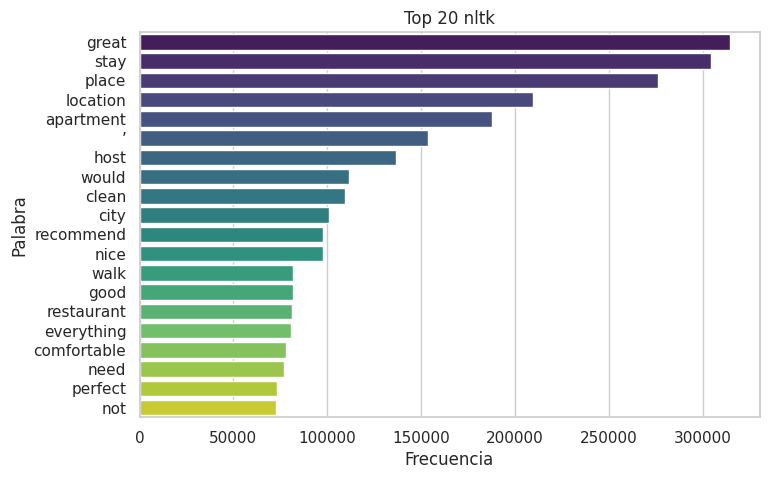

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
plots.plot_top_words(df_reviews_en, "final_comments_1", top_n=20, ax=ax, title="Top 20 nltk")
plt.show()

/home/tux/airbnb_comments/plots.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="viridis", ax=ax)


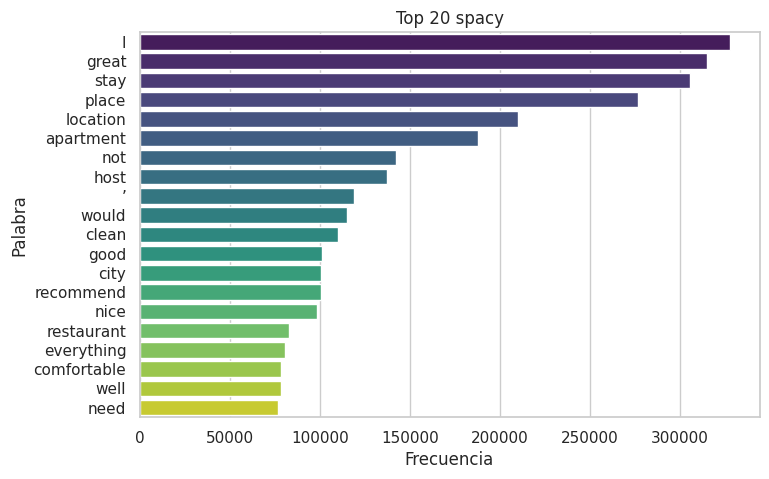

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
plots.plot_top_words(df_reviews_en, "final_comments", top_n=20, ax=ax, title="Top 20 spacy")
plt.show()

Vectorización
Para la vectorización del texto, utilizaremos TF-IDF (Term Frequency-Inverse Document Frequency) para convertir el texto preprocesado en vectores numéricos que puedan ser utilizados por los modelos de machine learning.

En esta parte, como se vectorizarpa basándonos en la variable target, tenemos que combinar los dataframes de reviews y listings para que la vectorización se realice sobre el texto de las reseñas correspondientes a cada listing.

In [ ]:
# text_col = 'final_comments_1'
# label_col = 'target'

# df_pos = df_reviews_en[df_reviews_en[label_col] == 1].copy()
# df_neg = df_reviews_en[df_reviews_en[label_col] == 0].copy()

KeyError: 'target'

In [ ]:
# common_params = {
#     'max_df': 0.90,
#     'min_df': 0.02,
#     'ngram_range': (1, 2),
#     'stop_words': stopwords.words('english')
# }

# vectorizer_pos = TfidfVectorizer(**common_params)
# vectorizer_neg = TfidfVectorizer(**common_params)

# tfidf_pos = vectorizer_pos.fit_transform(df_pos[text_col])
# features_pos = vectorizer_pos.get_feature_names_out()

# tfidf_neg = vectorizer_neg.fit_transform(df_neg[text_col])
# features_neg = vectorizer_neg.get_feature_names_out()


NameError: name 'df_pos' is not defined